# Prelim

`conda` is highly recommended for setting up the environment. The environments for running this primer can be set up using

```
# Create new conda environtment
conda create --name singlecell python==3.8

# Activate conda environment
conda activate singlecell


# Scanpy installation 
conda install seaborn scikit-learn statsmodels numba pytables
conda install -c conda-forge python-igraph leidenalg
pip install scanpy


# Other package instllation
pip install palantir
pip install seaborn
pip install harmonyTS
pip install cellxgene
pip install harmonypy
pip install pyranges

# umap version
pip install umap-learn==0.5.1

# jupyter/ipython installation 
conda install -c conda-forge jupyterlab
```

This primer will use a dataset provided by 10X: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3?

The raw and processed data should be downloaded to the `data/` folder.
1. [Raw data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5)
2. [Processed data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad)


# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Some plotting settings we use
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

# Scanpy

[scanpy](https://scanpy.readthedocs.io/en/stable/) is the main toolkit for single-cell RNA-seq data preprocessing and analysis. [Seurat](https://satijalab.org/seurat/) is the alternative package for single-cell RNA-seq data analysis in R.

Overview of the primer: 
- We will start by understanding the `Anndata` class which is the data container of `scanpy`. 
- We will perform QC of a publicly available dataset made by available by 10X using scanpy functions. This is a single-cell RNA-seq dataset of peripheral mononuclear blood cells from a healthy donor
- We will then cluster, generating umaps and annotate cell-types in this data.

Extensive tutorials about scanpy usage are available [here](https://scanpy.readthedocs.io/en/stable/tutorials.html).

# Anndata

`AnnData` is the central data container for single-cell data. These are the main components of the an `AnnData` object.

- `.X`: Expression matrix of cells X genes (Note that in R, genes X cells representation is used). This could be raw or normalized data. 
- `.obs`: `pandas` dataframe with information about cells. Each row is a cell. The number of rows in `.obs` is same as the number of rows in `.X`. Columns contain annotations about cells. E.g., sample, cluster, cell type etc..
- `.var`: Similar to `.obs` but with information about genes.
- `.obsm`: Dictionary of matrices about cells. Each entry of `.obsm` has the same number of rows as `.X` and `.obs`. This could matrix properties such as UMAPs, PCs etc.
- `.varm`: Similar to `.obsm` for genes 
- `.uns`: Dictionary of dictionaries with unstructured information. E.g: cluster colors, cell type colors

More details on the Anndata are [here](https://anndata.readthedocs.io/en/latest/)

## Load anndata

Lets start with loading a previously computed anndata using the `scanpy.read` function. You can download the object from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad). Download it to the `data/` folder.

In [8]:
# Load the 10x_pbmc.h5ad object
data_dir = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/'
ad = sc.read(data_dir + 'bm_multiome_rna_no_bcells.h5ad')

In [9]:
# Print out the ad object
ad

AnnData object with n_obs × n_vars = 7439 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

## Anndata exploration

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

In [10]:
ad.obs_names

Index(['IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACATAGCC-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACCTATAG-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCATTGCGGT-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCAACACAGCCTG-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGACAAAGT-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGATGCCTG-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGTCATCCC-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGTTGTCCC-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGCGTCATAGAT-1',
       'IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGGCAACATAAG-1',
       ...
       'IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGCGACATAAAGCA-1',
       'IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGCGGAGGCTAATC-1',
       'IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGCGGAGTTTCCGC-1',
       'IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGGCTGTACCAGGT-1',
       'IM-1393_BoneMarrow_TcellDep_2

As you can see each cell name is a nucleotide sequence indicating the cell barcode

In [11]:
ad.var_names

Index(['AL627309.1', 'AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115',
       'NOC2L', 'KLHL17', 'ISG15', 'C1orf159', 'AL390719.3',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'MAFIP', 'AL354822.1', 'AL592183.1'],
      dtype='object', length=17226)

Lets examine the `.obs` entry:

In [12]:
# head function lists the top n rows in the table
# Reiteration - ad.obs is just a dataframe and all pandas functions can be used.
ad.obs.head(n=10)

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,Metacell,Metacell_Entropy
index,,,,,,,,,,,,,,
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACATAGCC-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2089,4946.0,208.0,4.205419,0,0.068323,4933.0,1,1,3.694254,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#TGCGCAG...,0.740765
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACCTATAG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2065,4590.0,569.0,12.396515,0,0.127273,4583.0,2,1,3.661813,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#ATGTTGT...,1.267309
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCATTGCGGT-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2158,5111.0,710.0,13.891606,0,0.086187,5098.0,2,1,3.708506,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#ATGTTGT...,0.518340
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCAACACAGCCTG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2494,5964.0,579.0,9.708250,0,0.106040,5951.0,1,0,3.775538,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#TCGATTA...,2.607735
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGACAAAGT-1,IM-1393_BoneMarrow_TcellDep_1_multiome,3226,8735.0,1087.0,12.444190,0,0.059961,8711.0,6,5,3.941263,MyeloidPre,IM-1393_BoneMarrow_TcellDep_2_multiome#ACAGGCT...,0.843255
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGATGCCTG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2422,5756.0,554.0,9.624740,0,0.095477,5736.0,2,1,3.760121,Mono,IM-1393_BoneMarrow_TcellDep_2_multiome#CGGACAA...,2.879593
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGTCATCCC-1,IM-1393_BoneMarrow_TcellDep_1_multiome,4003,12564.0,698.0,5.555556,0,0.154783,12514.0,13,10,4.099128,BcellPre,IM-1393_BoneMarrow_TcellDep_2_multiome#TGATGAC...,1.798507
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGTTGTCCC-1,IM-1393_BoneMarrow_TcellDep_1_multiome,3149,7826.0,967.0,12.356249,0,0.210526,7793.0,13,10,3.893540,BcellPre,IM-1393_BoneMarrow_TcellDep_1_multiome#CGATTTG...,0.000000
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGCGTCATAGAT-1,IM-1393_BoneMarrow_TcellDep_1_multiome,1317,2237.0,91.0,4.067948,0,0.086187,2223.0,11,14,3.349666,ETP,IM-1393_BoneMarrow_TcellDep_1_multiome#ACACTAG...,2.472502


## Subsetting anndata

Anndata objects can be subset using cell names, gene names, logical vectors for cells and genes

In [13]:
# Anndata object with cell "AAACCCAAGATTGTGA-1"
ad["IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACATAGCC-1", :]

View of AnnData object with n_obs × n_vars = 1 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [14]:
# Anndata object of pDC cells
ad[ad.obs['celltype'] == 'Mono', :]

View of AnnData object with n_obs × n_vars = 4899 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

# Scanpy - plotting

`scanpy` contains the following broad categories of functions:

- `sc.pp`: Functions for preprocessing (Eg: PCA)
- `sc.tl`: Tool  interfaces (Eg. UMAP)
- `sc.pl`: Plotting
- `sc.external`: Interface for accessing tools developed by other labs (Eg:. `sc.external.tl.palantir`

Lets start with visualizations that we already explored using `cellxgene`

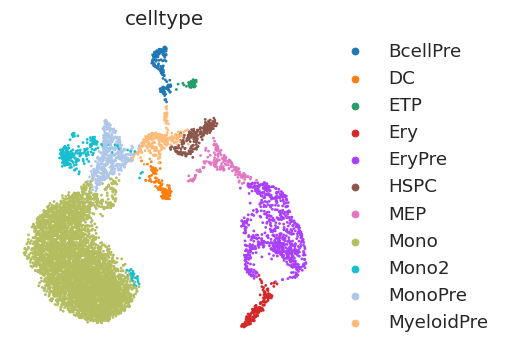

In [15]:
# Plot the umap colored by cell types
sc.pl.umap(ad, color='celltype', frameon=False)

The above function uses the `ad.obms['X_umap']` to plot the umap. If you want to use an alternative visualization, you can use the `sc.pl.scatter` function

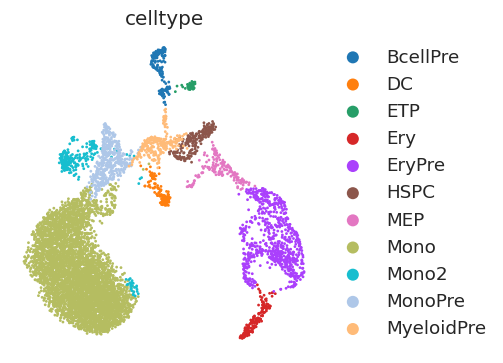

In [16]:
# Plot the umap colored by cell types
sc.pl.scatter(ad, color='celltype', basis='umap', frameon=False)

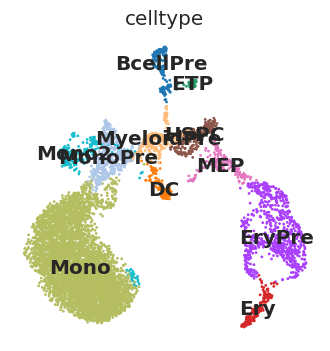

In [17]:
# We can highlight cell-types on the umap itself 
sc.pl.umap(ad, color='celltype', legend_loc='on data', frameon=False)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


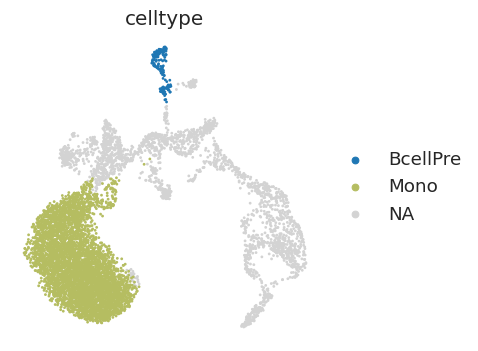

In [18]:
# Or plot specific cell types
sc.pl.umap(ad, color='celltype', groups=['Mono', 'BcellPre'], frameon=False)

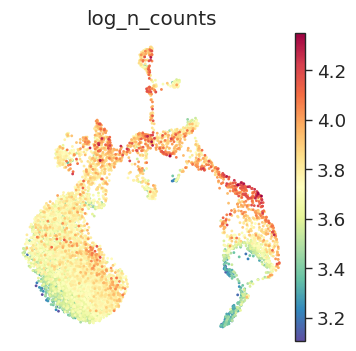

In [19]:
# UMAPs can be colored by continuous values too 
sc.pl.umap(ad, color='log_n_counts', frameon=False)

In [20]:
# Or by gene expression values 

## I don't understand how this block was initially supposed to work. there's no gene expression data in ad.obs 
#sc.pl.umap(ad, color= , frameon=False)

# Preprocess

This section will start with raw data and go through the preprocessing and QC

## Load data

In [21]:
#ad = sc.read_10x_h5('data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')
ad.var_names_make_unique()

In [22]:
ad

AnnData object with n_obs × n_vars = 7439 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

## QC

**Note:** With pandas >=1.3, `sc.pp.calculate_qc_metrics` throws a `ValueError`, should resolve in pandas >=1.4.
See [here](https://github.com/theislab/scanpy/issues/2008) for more details.

In [23]:
ad.var['mt'] = ad.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

### Filter cell based on RNA

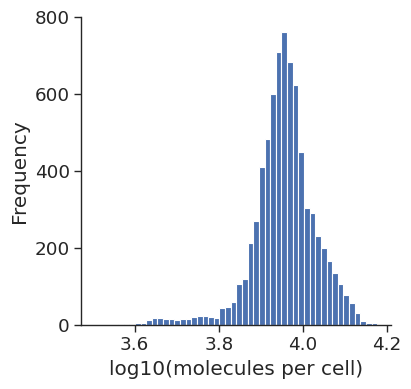

In [24]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

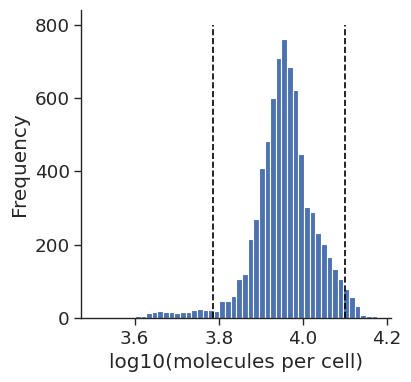

In [25]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

In [26]:
# Filter cells 
use_cells = ad.obs_names[(np.log10(ad.obs['total_counts']) > THRESHOLDS[0]) & \
    (np.log10(ad.obs['total_counts']) < THRESHOLDS[1]) ]
ad = ad[use_cells, :]

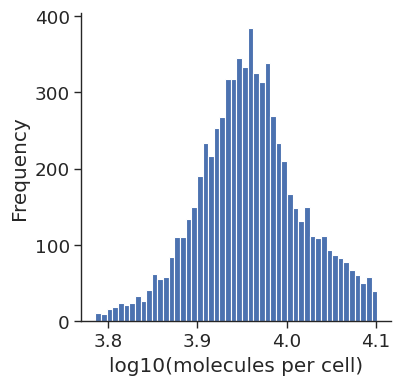

In [27]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

### Filter based on mitochondria

In [28]:
ad.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,103,False,0.035064,3.355888,0.588321,False,79,0.035064,98.938029,260.839081
AL627309.5,387,False,0.139959,3.281437,0.577855,False,310,0.139959,95.832773,1041.158691
LINC01409,993,False,0.309100,3.072204,-0.188153,False,704,0.309100,90.536362,2299.393799
LINC01128,627,True,0.187946,3.371612,2.253176,False,415,0.187946,94.421293,1398.129028
LINC00115,292,False,0.084814,3.250041,0.016006,False,194,0.084814,97.392123,630.931824
...,...,...,...,...,...,...,...,...,...,...
MT-ND6,6160,False,2.430453,1.684778,0.599241,True,4563,2.430453,38.661110,18080.136719
MT-CYB,10966,False,8.362069,0.083437,-3.374904,True,7432,8.362069,0.094099,62205.304688
MAFIP,413,False,0.115090,3.056032,-1.461697,False,279,0.115090,96.249496,856.151489
AL354822.1,185,False,0.045927,3.052282,-1.636362,False,115,0.045927,98.454093,341.653076


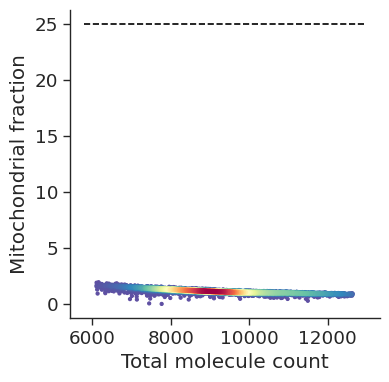

In [29]:
MITO_THRESHOLD = 25
#Mito fraction seems unusually low in this dataset
x,y,dens = palantir.plot.density_2d(ad.obs['total_counts'], 
               ad.obs['pct_counts_mt'])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')

plt.xlabel('Total molecule count')
plt.ylabel('Mitochondrial fraction')
sns.despine()


In [30]:
ad = ad[ad.obs['pct_counts_mt'] < MITO_THRESHOLD, :]

In [31]:
ad

View of AnnData object with n_obs × n_vars = 7066 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

## Analysis

In [32]:
# Filter genes 
sc.pp.filter_genes(ad, min_cells=50)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [33]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [34]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 7066 × 15453
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [35]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 7066 × 15453
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [36]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 7066 × 15453
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [37]:
# Diffusion maps 
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 7066 × 15453
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [38]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [00:46<00:00, 10.82it/s]

BarnesHut Approximation  took  19.73  seconds
Repulsion forces  took  23.79  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  1.07  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


In [39]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
ad

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2987313270568848 seconds
Jaccard graph constructed in 0.9051163196563721 seconds
Wrote graph to binary file in 0.10656905174255371 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.815046
After 2 runs, maximum modularity is Q = 0.817104
After 14 runs, maximum modularity is Q = 0.8182
After 15 runs, maximum modularity is Q = 0.81931
Louvain completed 35 runs in 6.204227447509766 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.144102811813354 seconds


AnnData object with n_obs × n_vars = 7066 × 15453
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [40]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = impute_data(dm_res, ad)

# Visualize results

In [41]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

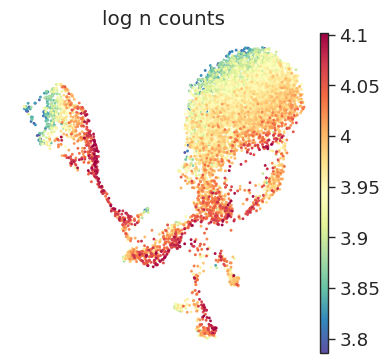

In [42]:
sc.pl.scatter(ad, basis='umap', color='log_n_counts', frameon=False)

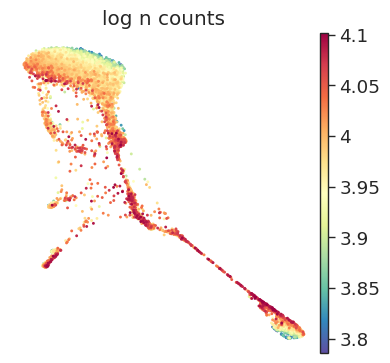

In [43]:
sc.pl.scatter(ad, basis='FDL', color='log_n_counts', frameon=False)

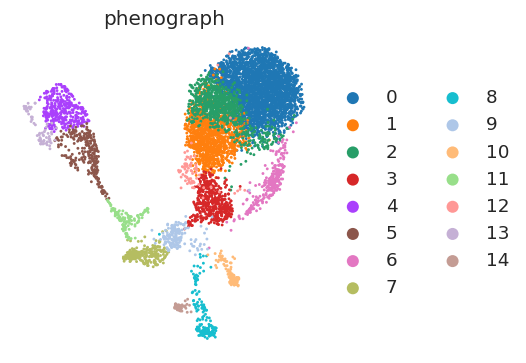

In [44]:
sc.pl.scatter(ad, basis='umap', color=['phenograph'], frameon=False)

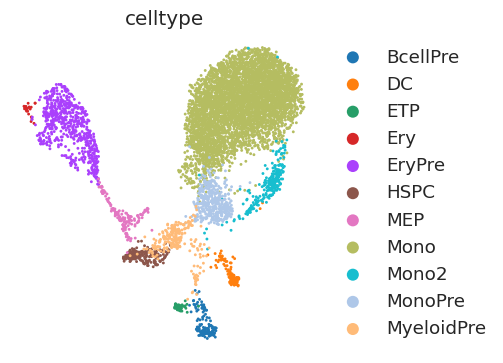

In [45]:
sc.pl.scatter(ad, basis = 'umap', color = ['celltype'], frameon=False)

# Celltype annotation

In [46]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

In [47]:
imp_df = pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names)



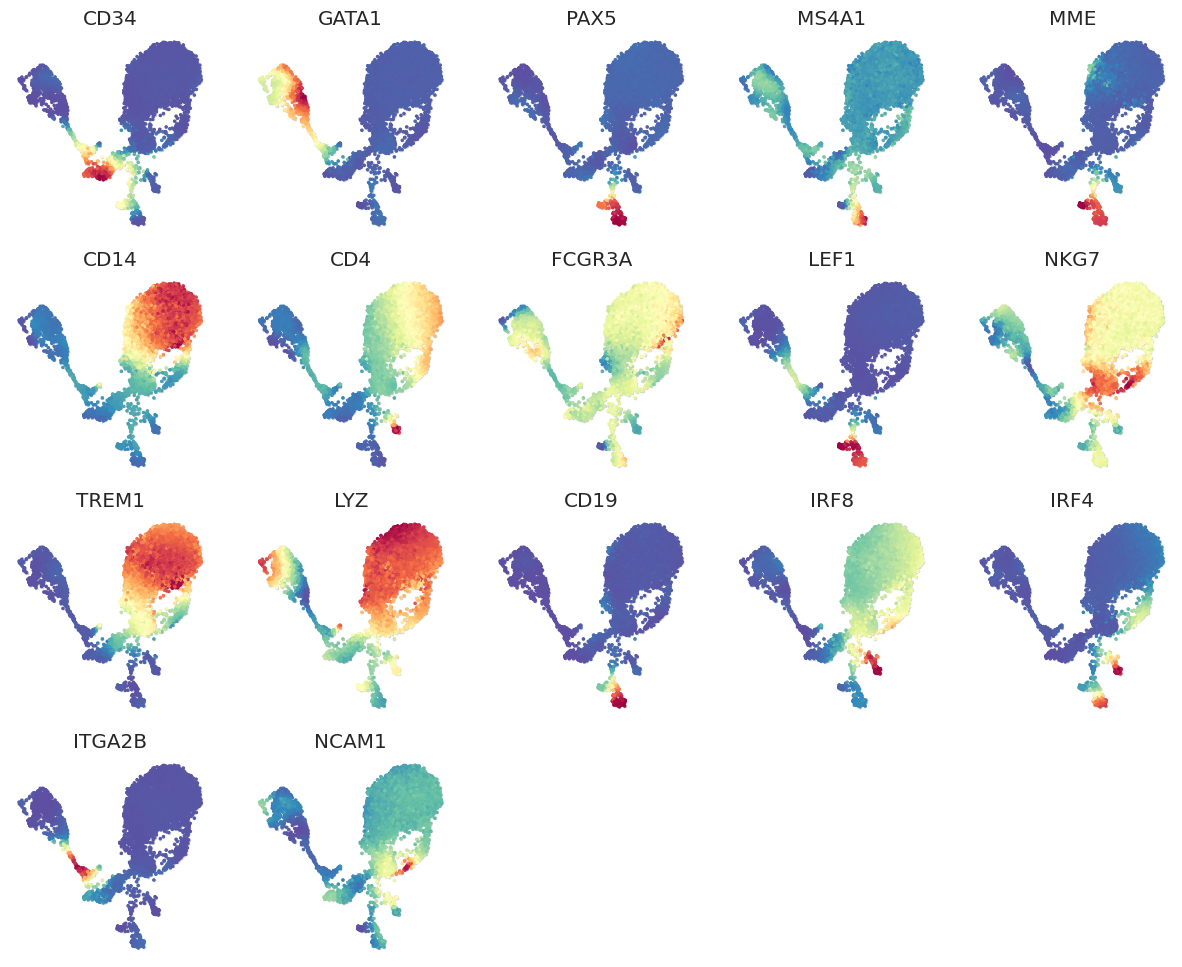

In [48]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

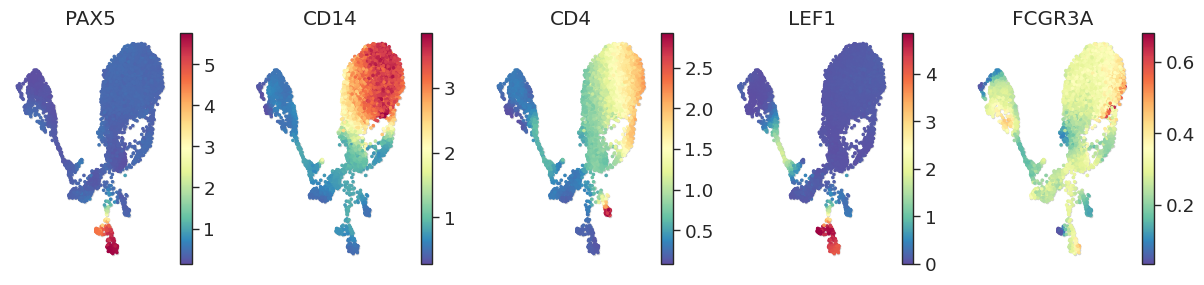

In [49]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   ['PAX5', 'CD14', 'CD4', 'LEF1', 'FCGR3A'], plot_scale=True)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


Text(0.5, 1.0, 'B cell signature')

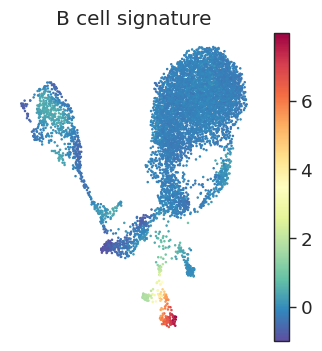

In [50]:
## Gene signatures 
bcell_signature = ["PAX5", "MS4A1"]

# Z-transform expression
from sklearn.preprocessing import scale
scaled_exprs = pd.DataFrame(scale(imp_df[bcell_signature]), index=imp_df.index, columns=bcell_signature)

# Aggregate 
vals = scaled_exprs.mean(axis=1)
plt.scatter(ad.obsm['X_umap'][:, 0], ad.obsm['X_umap'][:, 1], s=1, 
           c=vals)
plt.colorbar()
ax = plt.gca()
ax.set_axis_off()
plt.title('B cell signature')

In [51]:
ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,Metacell,Metacell_Entropy
index,,,,,,,,,,,,,,
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACATAGCC-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2078,8557.207031,89.141327,1.041711,0,0.068323,8539.187500,1,2,3.932332,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#TGCGCAG...,0.740765
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCACCTATAG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2059,8419.094727,109.700058,1.302991,0,0.127273,8407.616211,1,1,3.925266,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#ATGTTGT...,1.267309
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACATGCATTGCGGT-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2146,8554.464844,110.848045,1.295792,0,0.086187,8544.341797,1,1,3.932193,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#ATGTTGT...,0.518340
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCAACACAGCCTG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2481,9432.983398,104.342842,1.106149,0,0.106040,9401.237305,2,0,3.974649,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#TCGATTA...,2.607735
IM-1393_BoneMarrow_TcellDep_1_multiome#AAACCGAAGACAAAGT-1,IM-1393_BoneMarrow_TcellDep_1_multiome,3203,10920.221680,104.884590,0.960462,0,0.059961,10830.217773,6,9,4.038232,MyeloidPre,IM-1393_BoneMarrow_TcellDep_2_multiome#ACAGGCT...,0.843255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGTGAAGGCATTAC-1,IM-1393_BoneMarrow_TcellDep_2_multiome,2790,9914.362305,90.247124,0.910267,1,0.106383,9876.612305,8,8,3.996265,MyeloidPre,IM-1393_BoneMarrow_TcellDep_1_multiome#TGAACAA...,1.246366
IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGTGAAGGCCATCA-1,IM-1393_BoneMarrow_TcellDep_2_multiome,3219,10845.143555,117.443596,1.082914,1,0.071749,10788.815430,6,9,4.035235,MyeloidPre,IM-1393_BoneMarrow_TcellDep_2_multiome#GTGCACG...,2.268661
IM-1393_BoneMarrow_TcellDep_2_multiome#TTTGTGAAGGTCCGTA-1,IM-1393_BoneMarrow_TcellDep_2_multiome,1667,7537.309570,100.370316,1.331646,1,0.088608,7517.050781,1,1,3.877217,Mono,IM-1393_BoneMarrow_TcellDep_1_multiome#TGCGCAG...,1.003610


In [52]:
cell_types = pd.Series("", index=ad.obs['phenograph'].values.categories)
cell_types['0'] = 'Mono'
cell_types['1'] = 'Mono'
cell_types['2'] = 'MonoPre'
cell_types['3'] = 'EryPre'
cell_types['4'] = 'Mono2'
cell_types['5'] = 'EryPre'
cell_types['6'] = 'HSPC'
cell_types['7'] = 'MyeloidPre'
cell_types['8'] = 'BcellPre'
cell_types['9'] = 'MEP'
cell_types['10'] = 'DC'
cell_types['11'] = 'Mono'
cell_types['12'] = 'BcellPre'
cell_types['13'] = 'Mono'
cell_types['14'] = 'ETP'




In [53]:
ad.obs['celltype1'] = cell_types[ad.obs['phenograph']].values
ad.uns['celltype1_colors'] = ad.uns['celltype_colors']


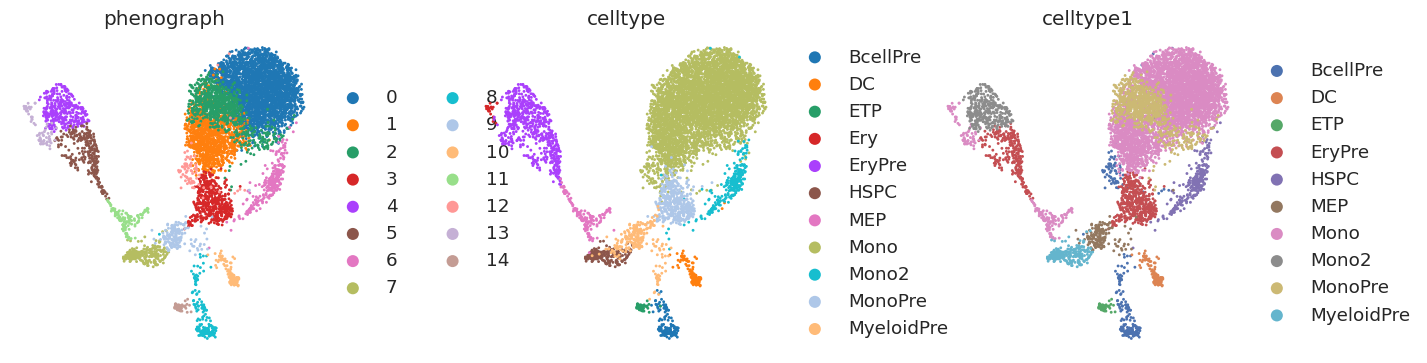

In [54]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'celltype', 'celltype1'], frameon=False)

# Save

In [55]:
ad.write('/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/tcell_dep_rna_processed.h5ad')

TypeError: No method has been defined for writing <class 'numpy.matrix'> elements to <class 'h5py._hl.group.Group'>

Above error raised while writing key 'MAGIC_imputed_data' of <class 'h5py._hl.group.Group'> to /